##Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

#Kriteria Submission
Berikut kriteria submission yang harus Anda penuhi:

1. Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.

2. Harus menggunakan LSTM dalam arsitektur model.

3. Validation set sebesar 20% dari total dataset.

4. Model harus menggunakan model sequential.

5. Harus menggunakan Learning Rate pada Optimizer.

6. MAE < 10% skala data.

#Saran Submission
1. Dataset yang digunakan memiliki banyak sampel data.

2. Mengimplementasikan Callback.

3. Membuat plot loss dan akurasi pada saat training dan validation.

Untuk latihan kali ini kita akan menggunakan dataset Daily Temperature of Major Cities (Daily average temperature values recorded in major cities of the world) yang terdiri dari 9132 baris yang dapat diperoleh dari https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities


In [1]:
from google.colab import files
files.upload()

Saving city_temperature.csv to city_temperature.csv


##Import Library

In [2]:
from datetime import datetime, date
from keras.preprocessing.sequence import TimeseriesGenerator
# from keras.models import Sequential, load_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

Langkah selanjutnya mengubah menjadi dataframe, dan menampilkannya dengan fungsi head()

In [4]:
data = pd.read_csv("city_temperature.csv")
data.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [24]:
data.head()

,AvgTemperature
Date,
1995-01-01,85.0
1995-01-02,82.3
1995-01-03,81.7
1995-01-04,83.1
1995-01-05,80.6


In [28]:
data.tail()

,AvgTemperature
Date,
2019-12-27,80.6
2019-12-28,82.0
2019-12-29,81.4
2019-12-30,84.6
2019-12-31,81.4


In [26]:
data.shape

(9132, 1)

##Preprocessing Dataset

In [5]:
data = data.loc[(data.City == 'Jakarta')]
data['Date'] = pd.to_datetime((data.Year*10000 + data.Month*100 + data.Day).apply(str), format='%Y%m%d')
data.AvgTemperature.replace(-99, np.NaN, inplace=True)
data.AvgTemperature.ffill(inplace=True)
data = data.loc[(data.Date >= '1995-01-01') & (data.Date < '2020-01-01'), ['Date', 'AvgTemperature']]
data.set_index('Date', inplace= True)
data.head()

,AvgTemperature
Date,
1995-01-01,85.0
1995-01-02,82.3
1995-01-03,81.7
1995-01-04,83.1
1995-01-05,80.6


##Split Dataset menjadi Data Training dan Data Testing

In [6]:
train, test = train_test_split(data.values, test_size=0.2, shuffle=False)

##Rescale Dataset

In [7]:
scaler = MinMaxScaler()
train_scale = scaler.fit_transform(train.reshape(-1, 1))
test_scale = scaler.fit_transform(test.reshape(-1, 1))

In [8]:
split=int((1-0.2)*len(data))

date_train = data.index[:split]
date_test = data.index[split:]

In [9]:
look_back = 20
train_gen = TimeseriesGenerator(train_scale, train_scale, length=look_back, batch_size=20)     
test_gen = TimeseriesGenerator(test_scale, test_scale, length=look_back, batch_size=1)

##Membangun Model Forecasting

In [10]:
model_forecast = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(look_back, 1)),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1)
])

model_forecast.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 32)            4352      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


##Run Model Forecasting yang telah dibuat dengan menggunakan Optimizer SGD

In [11]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model_forecast.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
model_forecast.fit_generator(train_gen, epochs=10, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
365/365 [==============================] - 6s 11ms/step - loss: 0.0755 - mae: 0.3512
Epoch 2/10
365/365 [==============================] - 4s 11ms/step - loss: 0.0192 - mae: 0.1570
Epoch 3/10
365/365 [==============================] - 4s 11ms/step - loss: 0.0128 - mae: 0.1254
Epoch 4/10
365/365 [==============================] - 4s 11ms/step - loss: 0.0123 - mae: 0.1232
Epoch 5/10
365/365 [==============================] - 4s 11ms/step - loss: 0.0119 - mae: 0.1220
Epoch 6/10
365/365 [==============================] - 4s 11ms/step - loss: 0.0117 - mae: 0.1204
Epoch 7/10
365/365 [==============================] - 4s 11ms/step - loss: 0.0113 - mae: 0.1188
Epoch 8/10
365/365 [==============================] - 4s 11ms/step - loss: 0.0110 - mae: 0.1167
Epoch 9/10
365/365 [==============================] - 4s 12ms/step - loss: 0.0108 - mae: 0.1161
Epoch 10/10
365/365 [==============================] - 4s 12ms/step - loss: 0.0105 - mae: 0.1146


##Prediksi Beberapa Rentang Data

In [12]:
pred = scaler.inverse_transform(model_forecast.predict_generator(test_gen))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


##Membandingkan MAE dan Skala Data 10%

In [13]:
mae = round(metrics.mean_absolute_error(data.values[split+look_back:],pred), 2)
scale10 = round((data.AvgTemperature.max() - data.AvgTemperature.min()) * (10 / 100), 2)

if mae < scale10:
  print("The MAE Score is " + str(mae) + " which is smaller than " + str(scale10) + ". It is a Good Model!")
else:
  print("The MAE Score is " + str(mae) + " which is greater than " + str(scale10) + ". Fix the model again!")

The MAE Score is 1.3 which is smaller than 1.93. It is a Good Model!


##Memvisualisasikan Data Asli

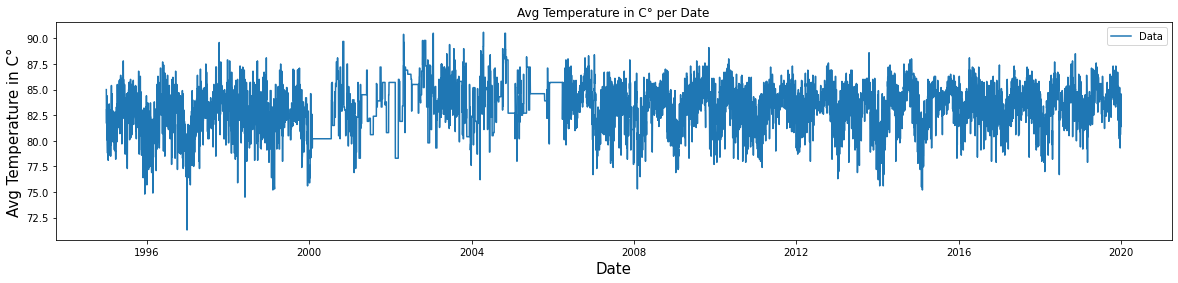

In [14]:
plt.figure(figsize=(20,4))
plt.plot(data.index, data.values, label = "Data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

##Memvisualisasikan Forecasting Data

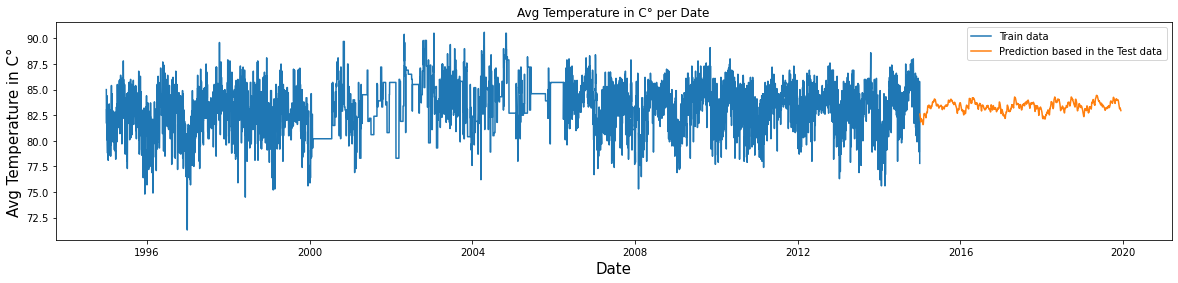

In [15]:
plt.figure(figsize=(20,4))
plt.plot(date_train, train, label = "Train data")
plt.plot(date_test[:-look_back], pred, label = "Prediction based in the Test data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

##Membandingkan Data Asli dengan Data Forecasting

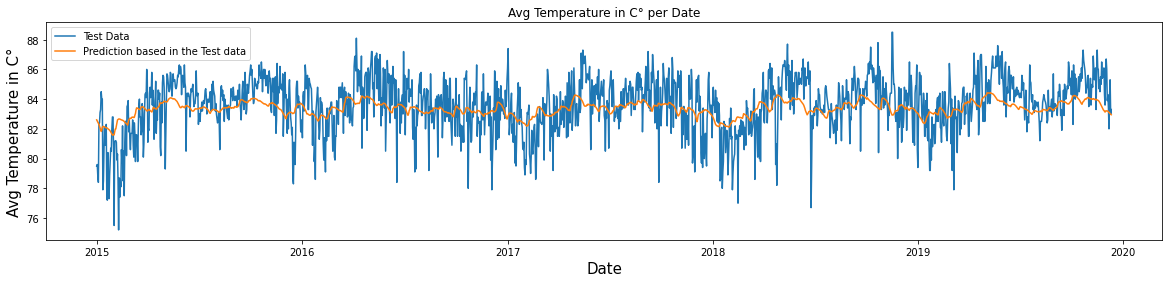

In [16]:
plt.figure(figsize=(20,4))
plt.plot(date_test[:-look_back], test.reshape(-1)[:-look_back], label = "Test Data")
plt.plot(date_test[:-look_back], pred, label = "Prediction based in the Test data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

##Run Model Forecasting dengan menggunakan Optimizer adam

In [17]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model_forecast.compile(loss='mae', optimizer='adam')
model_forecast.fit_generator(train_gen, epochs=10, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
365/365 [==============================] - 7s 14ms/step - loss: 0.1063
Epoch 2/10
365/365 [==============================] - 4s 12ms/step - loss: 0.0952
Epoch 3/10
365/365 [==============================] - 5s 13ms/step - loss: 0.0891
Epoch 4/10
365/365 [==============================] - 5s 12ms/step - loss: 0.0847
Epoch 5/10
365/365 [==============================] - 4s 11ms/step - loss: 0.0801
Epoch 6/10
365/365 [==============================] - 4s 12ms/step - loss: 0.0797
Epoch 7/10
365/365 [==============================] - 4s 12ms/step - loss: 0.0785
Epoch 8/10
365/365 [==============================] - 4s 12ms/step - loss: 0.0766
Epoch 9/10
365/365 [==============================] - 4s 12ms/step - loss: 0.0767
Epoch 10/10
365/365 [==============================] - 4s 12ms/step - loss: 0.0755


##Memprediksi Beberapa Rentang Data

In [18]:
pred = scaler.inverse_transform(model_forecast.predict_generator(test_gen))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


##Mmembandingkan MAE dan Skala Data 10%

In [19]:
mae = round(metrics.mean_absolute_error(data.values[split+look_back:],pred), 2)
scale10 = round((data.AvgTemperature.max() - data.AvgTemperature.min()) * (10 / 100), 2)

if mae < scale10:
  print("The MAE Score is " + str(mae) + " which is smaller than " + str(scale10) + ". It is a Good Model!")
else:
  print("The MAE Score is " + str(mae) + " which is greater than " + str(scale10) + ". Fix the model again!")

The MAE Score is 1.16 which is smaller than 1.93. It is a Good Model!


##Memvisualisasikan Data Asli

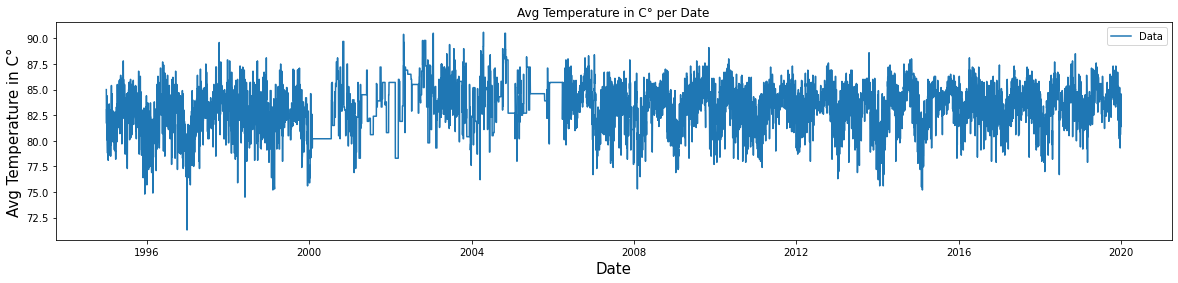

In [23]:
plt.figure(figsize=(20,4))
plt.plot(data.index, data.values, label = "Data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

##Memvisualisasikan Data Forecasting

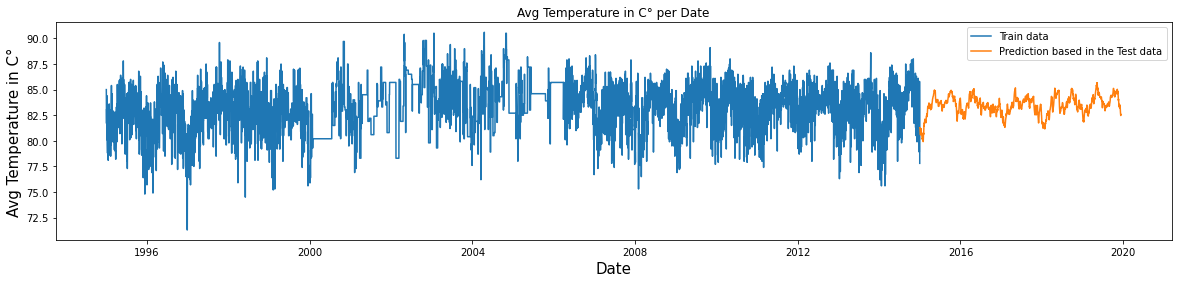

In [21]:

plt.figure(figsize=(20,4))
plt.plot(date_train, train, label = "Train data")
plt.plot(date_test[:-look_back], pred, label = "Prediction based in the Test data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

##Memmbandingkan Data Asli dengan Data Forecasting

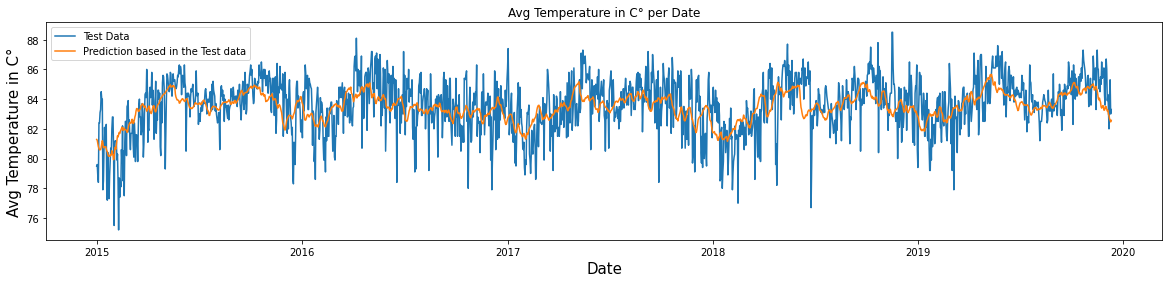

In [22]:
plt.figure(figsize=(20,4))
plt.plot(date_test[:-look_back], test.reshape(-1)[:-look_back], label = "Test Data")
plt.plot(date_test[:-look_back], pred, label = "Prediction based in the Test data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()